## 1. Importing Libraries

In [148]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
init_notebook_mode (connected=True)
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import plotly.io as pio
pio.renderers.default='notebook'
from IPython.display import Image

## 2. Loading Dataset

In [149]:
df=pd.read_csv('Covid-19_Dataset.csv')

In [150]:
df.head(2)

,id,case_in_country,reporting date,summary,location,country,gender,age,symptom_onset,If_onset_approximated,hosp_visit_date,exposure_start,exposure_end,visiting Wuhan,from Wuhan,death,recovered,symptom,source,link
0,765,15.0,02-10-20,new confirmed COVID-19 patient in Vietnam: 3 m...,Vinh Phuc,Vietnam,NaN,0.25,NaN,NaN,NaN,NaN,NaN,0,0,0,1,NaN,Vietnam News,https://vietnamnews.vn/society/591803/viet-nam...
1,477,27.0,02-05-20,new confirmed COVID-19 patient in Singapore: m...,Singapore,Singapore,male,0.50,NaN,NaN,NaN,1/23/2020,02-03-20,0,0,0,1,NaN,Straits Times,https://www.straitstimes.com/singapore/health/...


In [151]:
df.shape

(1085, 20)

In [152]:
df.dtypes

id                         int64
case_in_country          float64
reporting date            object
summary                   object
location                  object
country                   object
gender                    object
age                      float64
symptom_onset             object
If_onset_approximated    float64
hosp_visit_date           object
exposure_start            object
exposure_end              object
visiting Wuhan             int64
from Wuhan                 int64
death                      int64
recovered                  int64
symptom                   object
source                    object
link                      object
dtype: object

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   summary                1080 non-null   object 
 4   location               1085 non-null   object 
 5   country                1085 non-null   object 
 6   gender                 902 non-null    object 
 7   age                    843 non-null    float64
 8   symptom_onset          563 non-null    object 
 9   If_onset_approximated  560 non-null    float64
 10  hosp_visit_date        507 non-null    object 
 11  exposure_start         128 non-null    object 
 12  exposure_end           341 non-null    object 
 13  visiting Wuhan         1085 non-null   int64  
 14  from Wuhan             1085 non-null   int64  
 15  deat

## 3. Data Cleaning

First we remove unnecessary columns.

In [154]:
df.drop(['id','case_in_country','summary','symptom_onset', 'If_onset_approximated', 'hosp_visit_date', 'exposure_start',
'exposure_end', 'symptom', 'source', 'link'],axis=1,inplace=True)

Next we create a dataframe that shows the percentage of null values in each column of df.

In [155]:
100*df.isnull().sum()/df.shape[0]

reporting date     0.092166
location           0.000000
country            0.000000
gender            16.866359
age               22.304147
visiting Wuhan     0.000000
from Wuhan         0.000000
death              0.000000
recovered          0.000000
dtype: float64

Now we select the columns that contain between 0.5% and 70% null values, and replace the null values with the mean (for numerical columns) or median (for categorical columns) of each column.

In [156]:
df['age']= df['age']. fillna(df['age'].mean())

In [157]:
df_dum=pd.get_dummies(df['gender'].dropna(), drop_first=True)

In [158]:
df_dum['male'].median()

1.0

So we fill the null values in gender column with 'male'.

In [159]:
df['gender']= df['gender']. fillna('male')

Fianlly the columns that contain less than 0.5% null values are remained, and we drop the rows of df that contain these null values.

In [160]:
df.dropna(inplace=True)

In [161]:
df.isnull().sum()

reporting date    0
location          0
country           0
gender            0
age               0
visiting Wuhan    0
from Wuhan        0
death             0
recovered         0
dtype: int64

## 4. Feature Engineering

We rename some of the columns.

In [162]:
df.columns=df.columns.str.lower().str.replace(' ','_')

Now we change the format of date and add month column to df.

In [163]:
df['reporting_date']=pd.to_datetime(df['reporting_date'])

In [164]:
df['year']=df['reporting_date'].apply(lambda x:x.year)
df['month']=df['reporting_date'].apply(lambda x:x.month)

In [165]:
df['month'].unique()

array([2, 1], dtype=int64)

As there is only one year, we can remove the year column.

In [166]:
df.drop(['reporting_date', 'year'], axis=1, inplace=True)

In [167]:
df.head(2)

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,Vinh Phuc,Vietnam,male,0.25,0,0,0,1,2
1,Singapore,Singapore,male,0.50,0,0,0,1,2


## 5. Exploratory Data Analysis

We want to find the number of patients died and recovered based on their age.

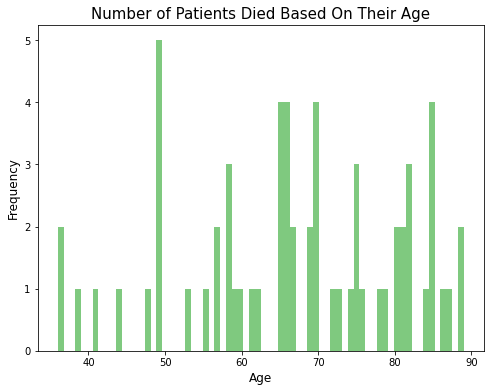

In [168]:
plt.figure(figsize=(8,6))
df[df['death']==1]['age'].plot(kind='hist',bins=70,colormap='Accent')
plt.title('Number of Patients Died Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

We can conclude that Pateints with age more than 48 have higher chance of death because of their weaker immune system.

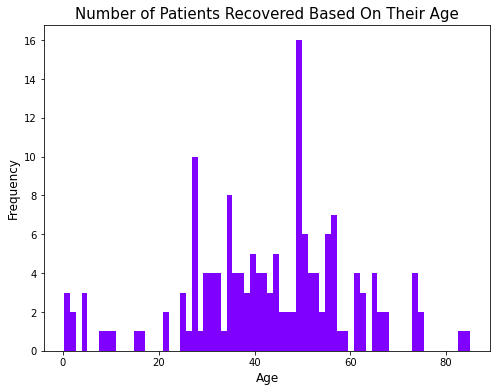

In [169]:
plt.figure(figsize=(8,6))
df[df['recovered']==1]['age'].plot(kind='hist',bins=70,colormap='rainbow')
plt.title('Number of Patients Recovered Based On Their Age',fontsize=15)
plt.xlabel('Age',fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()

Patients with age of 50 or lower have higher chance of recovery.

We calculate the current number of patients, those who recovered, diad, or those who arer receiving treatment.

In [170]:
print('Current count of patients:',df['death'].count())
print('Number of Dead Patients:', df[df['death']==1]['death'].count())
print('Number of Recovered Patients:',df[df['recovered']==1]['death'].count())
print('Number of Patients Receiving Treatment:',df[(df['death']==0)&(df['recovered']==0)]['death'].count())

Current count of patients: 1084
Number of Dead Patients: 63
Number of Recovered Patients: 159
Number of Patients Receiving Treatment: 862


We create bar plots for recovered and dead patients and categorize them versus gender.

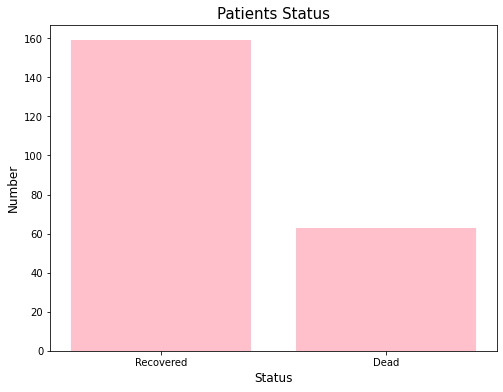

In [171]:
plt.figure(figsize=(8,6))
plt.bar(x=['Recovered','Dead'],height=[159,63], color='pink')
plt.title('Patients Status',fontsize=15)
plt.xlabel('Status', fontsize=12)
plt.ylabel('Number',fontsize=12)
plt.show()

Here, I categorized recovered and dead patients dependents on gender.

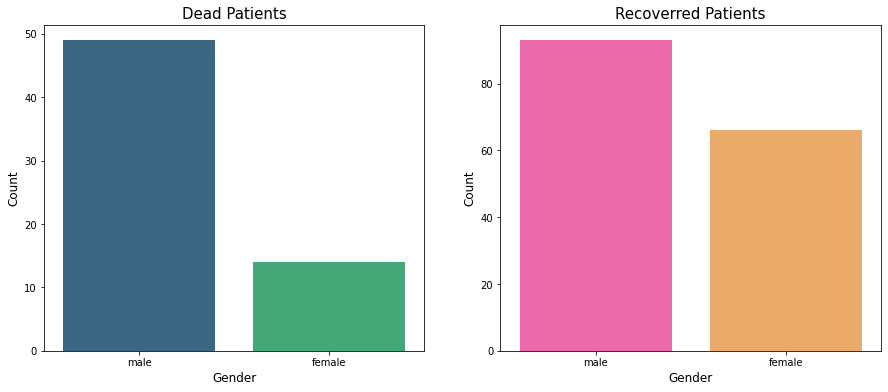

In [172]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='gender', data=df[df['death']==1], palette='viridis')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Dead Patients',fontsize=15)
plt.subplot(1,2,2)
sns.countplot(x='gender', data=df[df['recovered']==1], palette='spring')
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Recoverred Patients',fontsize=15)
plt.show()

Most of both dead and recovered patients were male.

We create Countplot of number of Covid patients in different countries.

In [173]:
country_order=list(df.groupby('country').count()['location'].sort_values(ascending=False).index)

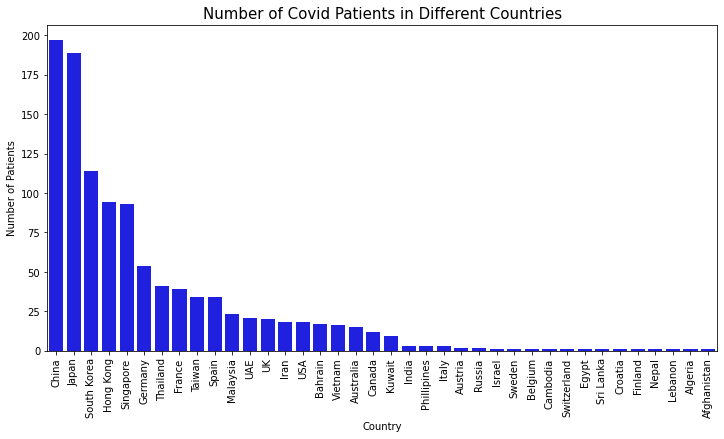

In [174]:
plt.figure(figsize=(12,6))
sns.countplot(x='country',data=df,color='blue',order=country_order)
plt.xticks(rotation=90)
plt.ylabel('Number of Patients')
plt.xlabel('Country')
plt.title('Number of Covid Patients in Different Countries',fontsize=15)
plt.show()

China and Japan have more patients as compared to others.

## 6. Prediction of Death or Recovery of Patients

### 6.1. Label Encoding

**Location**

In [175]:
le1=LabelEncoder()
le1.fit(df['location'])
df['location']=le1.transform(df['location'])

**Country**

In [176]:
le2=LabelEncoder()
le2.fit(df['country'])
df['country']=le2.transform(df['country'])

**Gender**

In [177]:
le3=LabelEncoder()
le3.fit(df['gender'])
df['gender']=le3.transform(df['gender'])

In [178]:
df.head()

,location,country,gender,age,visiting_wuhan,from_wuhan,death,recovered,month
0,141,37,1,0.25,0,0,0,1,2
1,118,26,1,0.50,0,0,0,1,2
2,118,26,1,1.00,0,0,0,1,2
3,42,8,0,2.00,1,0,0,0,1
4,60,22,1,2.00,0,0,0,1,1


### 6.2. Predicting the Recovery

#### 6.2.1. Splitting the Data

In [179]:
y=df['recovered']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 6.2.2. Logistic Regression

In [181]:
lr1=LogisticRegression()
lr1.fit(X,y)
predictions_lr1=lr1.predict(X_test)

C:\Users\afrid\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [182]:
print(confusion_matrix(y_test,predictions_lr1))
print('\n')
print(classification_report(y_test,predictions_lr1))

[[183   2]
 [ 29   3]]


              precision    recall  f1-score   support

           0       0.86      0.99      0.92       185
           1       0.60      0.09      0.16        32

    accuracy                           0.86       217
   macro avg       0.73      0.54      0.54       217
weighted avg       0.82      0.86      0.81       217



#### 6.2.3. Random Forest Classifier

In [183]:
rfc1=RandomForestClassifier(n_estimators=200)
rfc1.fit(X_train,y_train)
predictions_rfc1=rfc1.predict(X_test)

In [184]:
print(confusion_matrix(y_test,predictions_rfc1))
print('\n')
print(classification_report(y_test,predictions_rfc1))

[[179   6]
 [ 12  20]]


              precision    recall  f1-score   support

           0       0.94      0.97      0.95       185
           1       0.77      0.62      0.69        32

    accuracy                           0.92       217
   macro avg       0.85      0.80      0.82       217
weighted avg       0.91      0.92      0.91       217



#### 6.2.4. XGBoost Classifier

In [185]:
xgbc1=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc1.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [186]:
predictions_xgbc1=xgbc1.predict(X_test)

In [187]:
print(confusion_matrix(y_test,predictions_xgbc1))
print('\n')
print(classification_report(y_test,predictions_xgbc1))

[[180   5]
 [ 11  21]]


              precision    recall  f1-score   support

           0       0.94      0.97      0.96       185
           1       0.81      0.66      0.72        32

    accuracy                           0.93       217
   macro avg       0.88      0.81      0.84       217
weighted avg       0.92      0.93      0.92       217



In [188]:
print('Accuracy Score, Logistic Regression: ', round(accuracy_score(y_test,predictions_lr1),ndigits=3))

print('Accuracy Score, Random Forest Classifier: ', round(accuracy_score(y_test,predictions_rfc1),ndigits=3))

print('Accuracy Score, XGBoost Classifier: ', round(accuracy_score(y_test,predictions_xgbc1), ndigits=2))

Accuracy Score, Logistic Regression:  0.857
Accuracy Score, Random Forest Classifier:  0.917
Accuracy Score, XGBoost Classifier:  0.93


So we conclude that XGBoost Classifier with the accuracy of 93% is the best model for predicting the number of recovered patients.

### 6.3. Predicting the Death

#### 6.3.1. Splitting the Data

In [189]:
y=df['death']
X=df[['location','country','gender','age','visiting_wuhan','from_wuhan','month']]

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### 6.3.2. Logistic Regression

In [191]:
lr2=LogisticRegression()
lr2.fit(X,y)
predictions_lr2=lr2.predict(X_test)

C:\Users\afrid\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [192]:
print(confusion_matrix(y_test,predictions_lr2))
print('\n')
print(classification_report(y_test,predictions_lr2))

[[201   1]
 [ 11   4]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       202
           1       0.80      0.27      0.40        15

    accuracy                           0.94       217
   macro avg       0.87      0.63      0.69       217
weighted avg       0.94      0.94      0.93       217



#### 6.3.4. Random Forest Classifier

In [193]:
rfc2=RandomForestClassifier(n_estimators=200)
rfc2.fit(X_train,y_train)
predictions_rfc2=rfc2.predict(X_test)

In [194]:
print(confusion_matrix(y_test,predictions_rfc2))
print('\n')
print(classification_report(y_test,predictions_rfc2))

[[202   0]
 [  8   7]]


              precision    recall  f1-score   support

           0       0.96      1.00      0.98       202
           1       1.00      0.47      0.64        15

    accuracy                           0.96       217
   macro avg       0.98      0.73      0.81       217
weighted avg       0.96      0.96      0.96       217



#### 6.3.6. XGBoost Classifier

In [195]:
xgbc2=xgb.XGBClassifier(n_estimators=200, learning_rate=0.08, gamma=0, subsample=0.5,colsample_bytree=1, max_depth=8)
xgbc2.fit(X_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, gpu_id=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.08, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [196]:
predictions_xgbc2=xgbc2.predict(X_test)

In [197]:
print(confusion_matrix(y_test,predictions_xgbc2))
print('\n')
print(classification_report(y_test,predictions_xgbc2))

[[201   1]
 [ 10   5]]


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       202
           1       0.83      0.33      0.48        15

    accuracy                           0.95       217
   macro avg       0.89      0.66      0.72       217
weighted avg       0.94      0.95      0.94       217



In [198]:
print('Accuracy Score, Logistic Regression: ', round(accuracy_score(y_test,predictions_lr2),ndigits=3))
print('Accuracy Score, Random Forest Classifier: ', round(accuracy_score(y_test,predictions_rfc2),ndigits=3))
print('Accuracy Score, XGBoost Classifier: ', round(accuracy_score(y_test,predictions_xgbc2), ndigits=3))

Accuracy Score, Logistic Regression:  0.945
Accuracy Score, Random Forest Classifier:  0.963
Accuracy Score, XGBoost Classifier:  0.949


So we conclude that Random Forest Classifier with the accuracy of 96.3% is the best model for predicting the number of dead patients.

## 7. Conclusion

- Here, I performed Data Cleaning and Feature Engineering to convert the dataset to an acceptable format.

-  Here, I performed Exploratory Data Analysis and determined the factors that were more important in the death and recovery of patients

-  XGBoost Classifier with the accuracy of 93% was the best model for predicting the number of recovered patients. 

-  Random Forest Classifier with the accuracy of 96.3% was the best model for predicting the number of dead patients.